# After completing Udacity's Deep Learning Course, I learned from their example of Convolutional Neural Networks and I adapted it to Identify Distracted Drivers from the Kaggle Competition All State Challenge.

# Description from The Kaggle Website:

https://www.kaggle.com/c/state-farm-distracted-driver-detection

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.

Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?

Your goal is to predict the likelihood of what the driver is doing in each picture. 

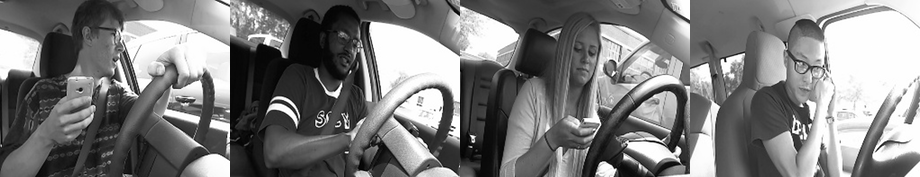

In [1]:
from IPython.display import Image
Image(filename='drivers_statefarm.png')

The 10 classes to predict are:

c0: safe driving

c1: texting - right

c2: talking on the phone - right

c3: texting - left

c4: talking on the phone - left

c5: operating the radio

c6: drinking

c7: reaching behind

c8: hair and makeup

c9: talking to passenger

In [1]:
from __future__ import print_function
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.misc import imresize
from scipy.ndimage import imread
from six.moves import cPickle as pickle
%matplotlib inline

In [ ]:
def extract_features(image_dir):
    s = image_dir + '/*'
    directory = glob.glob(s)  
    image_feature = []
    pixel_depth = 255.0
    WIDTH, HEIGHT =64 , 48
    for image in directory:
        img = imresize(imread(image), (HEIGHT, WIDTH))  # resizing and normalizing the image
        p = img.astype(float) / pixel_depth
        p = p.reshape(48,-1)
        image_feature.append(p)
    return np.array(image_feature)

In [ ]:
image_pickle = glob.glob('*.pickle')  # extracting image features and storing it for later use
image_dir = directory
for i,j in zip(image_dir,image_pickle):
    features = extract_features(i) 
    with open(j, 'wb') as f:
        pickle.dump(features, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('c0.pickle','rb') as f: # loading saved data
    setting = pickle.load(f)

In [7]:
train_datasets = glob.glob('c*') # collecting pickled files

In [8]:
for i in train_datasets:  # verifying that the dataset is balanced
     with open(i,'rb') as f:
        data_set = pickle.load(f)
        print(len(data_set))

2489
2267
2317
2346
2326
2312
2325
2002
1911
2129


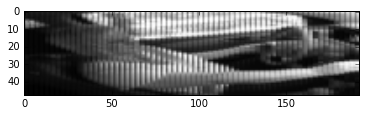

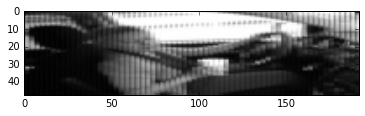

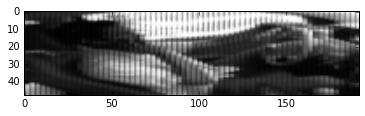

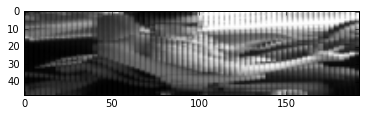

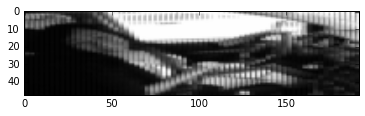

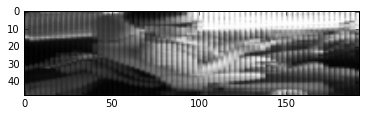

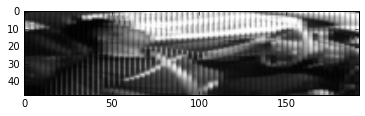

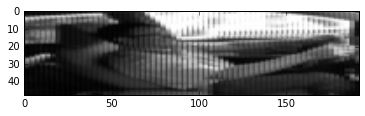

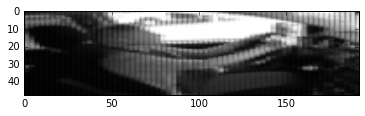

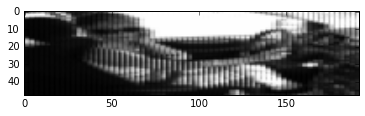

In [163]:
for i in train_datasets:   # viewing randomly selected images as a check
    with open(i,'rb') as f:
        letter_set = pickle.load(f)
        sample_idx = np.random.randint(len(letter_set))
        sample_image = letter_set[sample_idx] 
        plt.figure()
        plt.imshow(sample_image, cmap='gray')

In [167]:
 width, height =192 , 48
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows,height, width), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, height)
  train_dataset, train_labels = make_arrays(train_size, height)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 9500
valid_size = 9500

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)

Training: (9500, 48, 192) (9500,)
Validation: (9500, 48, 192) (9500,)


In [179]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [185]:
height = 48
width = 192
num_labels =10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, height ,width, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (9500, 48, 192, 1) (9500, 10)
Validation set (9500, 48, 192, 1) (9500, 10)


In [187]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [188]:
batch_size = 32
patch_size = 5
depth = 4
num_hidden = 16
beta = 0.01
graph = tf.Graph()


with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, height, width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [height // 4 * width // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    pool = tf.contrib.layers.batch_norm(pool)
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    pool = tf.contrib.layers.batch_norm(pool)
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  logits = tf.nn.dropout(logits,.96)
  #logits = tf.matmul(logits, layer1_weights) + layer1_biases
  logits = tf.nn.relu(logits)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
    beta*tf.nn.l2_loss(layer1_weights) +
    beta*tf.nn.l2_loss(layer1_biases)+
    beta*tf.nn.l2_loss(layer2_weights) +
    beta*tf.nn.l2_loss(layer2_biases) +
    beta*tf.nn.l2_loss(layer3_weights) +
    beta*tf.nn.l2_loss(layer3_biases)+
    beta*tf.nn.l2_loss(layer4_weights) +
    beta*tf.nn.l2_loss(layer4_biases)) 
    
  # Optimizer.
  global_step = tf.Variable(1)
  starter_learning_rate = .1
  learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10000000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))

In [191]:
num_steps = 5000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))

Initialized
Minibatch loss at step 0: 4.091551
Minibatch accuracy: 15.6%
Validation accuracy: 9.9%
Minibatch loss at step 1000: 1.110093
Minibatch accuracy: 84.4%
Validation accuracy: 84.5%
Minibatch loss at step 2000: 0.908804
Minibatch accuracy: 87.5%
Validation accuracy: 87.4%
Minibatch loss at step 3000: 0.385443
Minibatch accuracy: 96.9%
Validation accuracy: 96.8%
Minibatch loss at step 4000: 0.295540
Minibatch accuracy: 100.0%
Validation accuracy: 93.7%


# After Splitting the data to train and validation, I was able to get a 93.7% result on accuracy.  

# Source

VANHOUCKE, V. AND CHAKRABORTY, A.

Udacity

In-text: (Vanhoucke and Chakraborty)

Your Bibliography: Vanhoucke, Vincent and Arpan Chakraborty. "Udacity". Classroom.udacity.com. N.p., 2017. Web. 14

Mar. 2017.